# Analyse de réseau — Clubs liés via coachs communs

## Objectif

Dans ce notebook, nous analysons les **relations entre clubs**(20 clubs de Serie A 2024-2025) à travers les **coachs qu'ils ont en commun**.

L'idée est de construire un graphe dans lequel deux clubs sont reliés s'ils ont **partagé au moins un même entraîneur**, à n'importe quelle époque.

Cette analyse permet :
- de visualiser les **circulations d'entraîneurs** entre clubs
- d'identifier des **clusters** ou sous-groupes (clubs qui partagent souvent les mêmes profils)
- de repérer les **hubs** (clubs très connectés)

Nous utiliserons ici la base de données **SQLite**, construite à partir de Wikidata, et la librairie **NetworkX** pour l’analyse de graphe.


## Requête SQL utilisée (SQLite Studio)

La requête ci-dessous a été exécutée dans **SQLite Studio** afin d'extraire les coachs et les clubs qu'ils ont entraînés.  
Ces données seront ensuite utilisées pour construire le graphe biparti.

```sql
SELECT 
  c.name AS coach_name,
  t.Name AS team_name
FROM mandates m
JOIN coaches c ON m.coach_qid = c.wikidata_id
JOIN teams t ON m.team_qid = t.Qid


In [17]:

import pandas as pd

df = pd.read_csv("Coach_Club_Pairs.csv")


#print(f"Nombre de lignes : {len(df)}")
df.head()


,coach_name,team_name
0,Dino Zoff,Italy national under-23 football team
1,Dino Zoff,Juventus FC
2,Dino Zoff,SS Lazio
3,Dino Zoff,SS Lazio
4,Dino Zoff,Italy men's national association football team


In [18]:
import networkx as nx

# Création d’un graphe non orienté
G = nx.Graph()

# Ajout des nœuds et arêtes
for _, row in df.iterrows():
    coach = row["coach_name"]
    club = row["team_name"]
    
    G.add_node(coach, type="coach")
    G.add_node(club, type="club")
    G.add_edge(coach, club)

print(f"🔹 Nombre total de nœuds : {G.number_of_nodes()}")
print(f"🔸 Nombre total d’arêtes : {G.number_of_edges()}")


🔹 Nombre total de nœuds : 473
🔸 Nombre total d’arêtes : 785


In [5]:
from networkx.algorithms import bipartite

# Sélectionner uniquement les nœuds de type "club"
clubs = [n for n, d in G.nodes(data=True) if d["type"] == "club"]

# Projeter le graphe sur les clubs
G_club = bipartite.weighted_projected_graph(G, clubs)

print(f"📌 Nombre de clubs dans le graphe projeté : {G_club.number_of_nodes()}")
print(f"🔗 Nombre de liens (arêtes) entre clubs : {G_club.number_of_edges()}")


📌 Nombre de clubs dans le graphe projeté : 300
🔗 Nombre de liens (arêtes) entre clubs : 3033


In [7]:
from pyvis.network import Network

# Création de l’objet réseau
net = Network(height="750px", width="100%", notebook=True, bgcolor="#ffffff")

# Importer le graphe NetworkX dans Pyvis
net.from_nx(G_club)

net.show("network_clubs.html", notebook=False)


# Sauvegarder + afficher
net.show("network_clubs.html")


network_clubs.html
network_clubs.html


In [19]:
serieA_2024_25 = [
    "SSC Napoli", "Inter Milan", "Juventus FC", "Atalanta BC", "A.S. Roma", "ACF Fiorentina",
    "SS Lazio", "AC Milan", "Bologna F.C. 1909", "Torino FC", "Como 1907", "Udinese Calcio",
    "Genoa CFC", "Hellas Verona FC", "Cagliari Calcio", "Parma Calcio 1913", "US Lecce",
    "Empoli FC", "Venezia F.C.", "AC Monza"
]

# Filtrer le DataFrame pour ne garder que ces clubs
df_filtered = df[df["team_name"].isin(serieA_2024_25)]

print(f"Paires restantes après filtrage : {len(df_filtered)}")
df_filtered.head()


Paires restantes après filtrage : 315


,coach_name,team_name
1,Dino Zoff,Juventus FC
2,Dino Zoff,SS Lazio
3,Dino Zoff,SS Lazio
5,Dino Zoff,SS Lazio
6,Dino Zoff,ACF Fiorentina


In [13]:
G = nx.Graph()
for _, row in df_filtered.iterrows():
    coach = row["coach_name"]
    club = row["team_name"]
    
    G.add_node(coach, type="coach")
    G.add_node(club, type="club")
    G.add_edge(coach, club)

# Projection club ↔ club
clubs = [n for n, d in G.nodes(data=True) if d["type"] == "club"]
G_club = bipartite.weighted_projected_graph(G, clubs)

# Visualisation
net = Network(height="750px", width="100%", notebook=True, cdn_resources="in_line")
net.from_nx(G_club)
net.show("network_clubs_serieA_2024.html")


network_clubs_serieA_2024.html


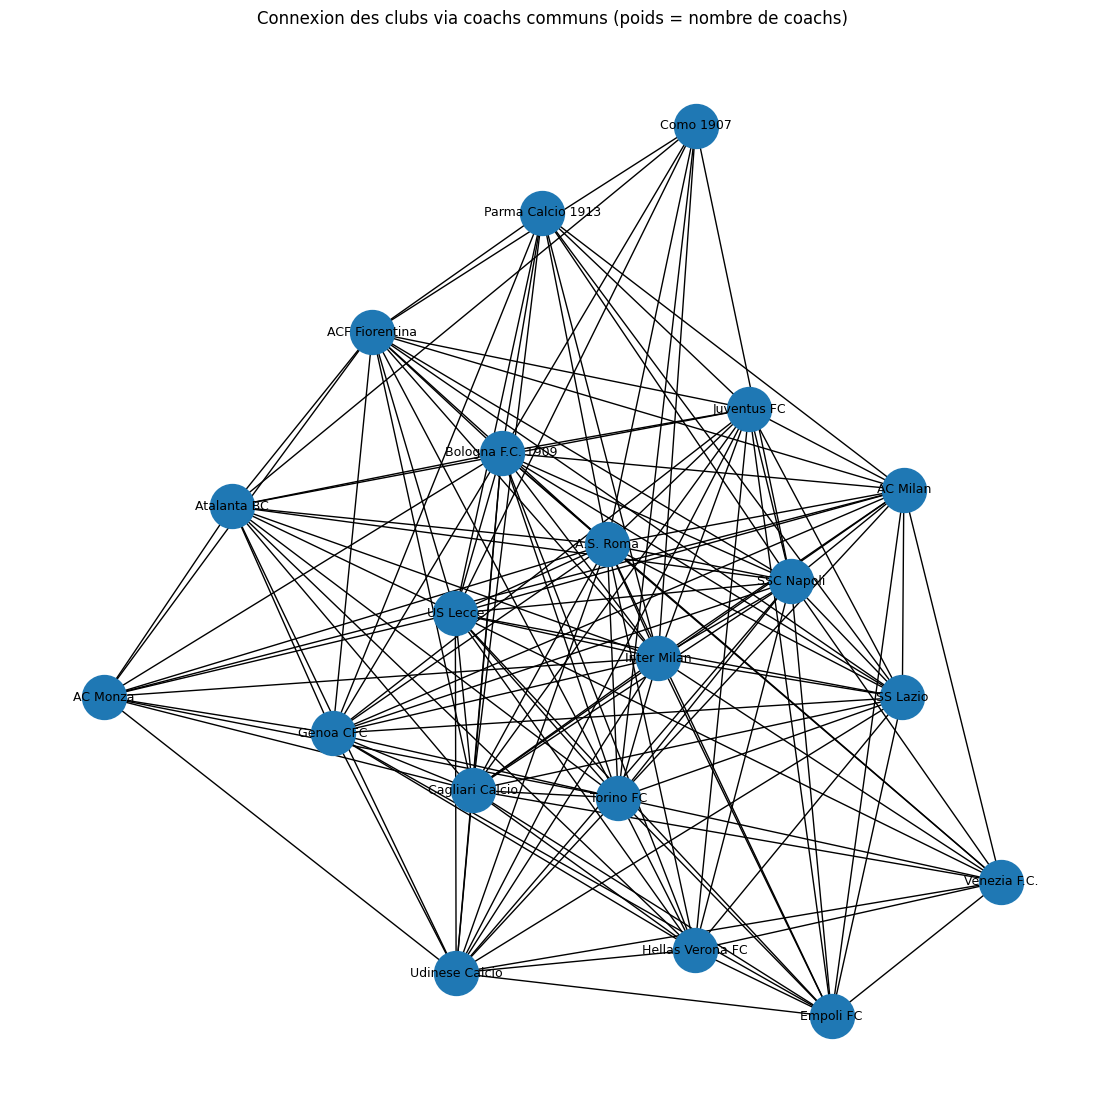

In [16]:



import matplotlib.pyplot as plt


pos = nx.spring_layout(G_club, seed=42)

# Affichage du graphe
plt.figure(figsize=(14, 14))
nx.draw_networkx(G_club, pos, with_labels=True, node_size=1000, font_size=9)

# Poids sur les arêtes (nombre de coachs en commun)
edge_labels = nx.get_edge_attributes(G_club, "weight")
nx.draw_networkx_edge_labels(G_club, pos, edge_labels=edge_labels, font_size=8)

plt.title("Connexion des clubs via coachs communs (poids = nombre de coachs)")
plt.axis("off")
plt.show()


### Analyse du graphe : connexions entre clubs via coachs communs

Ce graphe représente les **clubs de Serie A 2024-2025** reliés entre eux lorsqu’ils ont partagé **au moins un coach** dans leur histoire.

- Chaque **nœud** correspond à un club.
- Une **arête** relie deux clubs lorsqu’ils ont eu un ou plusieurs coachs en commun.
- L’étiquette sur les arêtes indique le **nombre de coachs partagés**.

#### Observations :

- Certains clubs comme **Juventus**, **AC Milan** ou **Inter** sont très connectés, ce qui reflète une forte circulation d’entraîneurs entre clubs majeurs.
- D’autres comme **Como** ou **Venezia** apparaissent plus isolés, probablement en raison d’une présence plus irrégulière en Serie A.

Ce graphe met en évidence la **densité du marché des entraîneurs** au sein du championnat italien.
